# Installation

In [1]:
!pip install --upgrade pip
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

# Standard installs
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install dm-tree
!pip install chex
!sudo apt-get install -y xvfb ffmpeg
!pip install imageio
!pip install gym
!pip install gym[classic_control]

!apt-get install x11-utils
!pip install pyglet

!pip install gym pyvirtualdisplay

from IPython.display import clear_output
clear_output()

In [2]:
!unset LD_PRELOAD
import os
%set_env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib/nvidia
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc 
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc 
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco-py<2.2,>=2.1'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco_py
  _mujoco_run_once = True

clear_output()

# Imports

In [3]:
%matplotlib inline
import IPython
from IPython.display import HTML
from IPython import display as ipythondisplay

import acme
from acme import datasets
from acme import types
from acme import specs
from acme.wrappers import gym_wrapper
import base64
from base64 import b64encode
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import imageio
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import multiprocessing as mp
import multiprocessing.connection
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time
import tree
from typing import *
import warnings
import pyglet
pyglet.options['search_local_libs'] = False
pyglet.options['shadow_window']=False
from pyglet.window import xlib
xlib._have_utf8 = False

from pyvirtualdisplay import Display
display = Display(visible=False, size=(1400, 900))
display.start()

import mujoco_py
 
np.set_printoptions(precision=3, suppress=1)

%matplotlib inline

# Environments

## Inverted pendulum

### Environment wrapper

In [4]:
class PendulumEnv(dm_env.Environment):
  def __init__(self, for_evaluation: bool) -> None:
    self._env = gym.make('Pendulum-v0')
    self._for_evaluation = for_evaluation
    if self._for_evaluation:
      self.screens = []

  def step(self, action: chex.ArrayNumpy) -> dm_env.TimeStep:
    new_obs, reward, done, _ = self._env.step(action)
    if self._for_evaluation:
      self.screens.append(self._env.render(mode='rgb_array'))
    if done:
      return dm_env.termination(reward, new_obs)
    return dm_env.transition(reward, new_obs)

  def reset(self) -> dm_env.TimeStep:
    obs = self._env.reset()
    if self._for_evaluation:
      self.screens.append(self._env.render(mode='rgb_array'))
    return dm_env.restart(obs)

  def observation_spec(self) -> specs.BoundedArray:
    return specs.BoundedArray(shape=(3,), minimum=-8., maximum=8., dtype=np.float32)

  def action_spec(self) -> specs.BoundedArray:
    return specs.BoundedArray(shape=(1,), minimum=-2., maximum=2., dtype=np.float32)

  def close(self) -> None:
    self._env.close()

### Visualizing with random agent

In [5]:
import abc

@chex.dataclass
class Trajectory:
  observations: types.NestedArray  # [T, B, ...]
  actions: types.NestedArray  # [T, B, ...]
  rewards: chex.ArrayNumpy  # [T, B]
  dones: chex.ArrayNumpy  # [T, B]
  discounts: chex.ArrayNumpy # [T, B]

# A very simple agent API, with just enough to interact with the environment
# and to update its potential parameters.
class Agent(abc.ABC):
  @abc.abstractmethod
  def learner_step(self, trajectory: Trajectory) -> Mapping[str, chex.ArrayNumpy]:
    """One step of learning on a trajectory.
    
    The mapping returned can contain various logs.
    """
    pass

  @abc.abstractmethod
  def batched_actor_step(self, observations: types.NestedArray) -> types.NestedArray:
    """Returns actions in response to observations.
    
    Observations are assumed to be batched, i.e. they are typically arrays, or
    nests (think nested dictionaries) of arrays with shape (B, F_1, F_2, ...)
    where B is the batch size, and F_1, F_2, ... are feature dimensions.
    """
    pass


In [6]:
class RandomAgentPendulum(Agent):
  def __init__(self, environment_spec: specs.EnvironmentSpec) -> None:
    self.action_spec = environment_spec.actions

  def batched_actor_step(self, observation: types.NestedArray) -> types.NestedArray:
    batch_size = tree.flatten(observation)[0].shape[0]
    return [[4*np.random.random() - 2] for _ in range(batch_size)]

  def learner_step(self, trajectory: Trajectory) -> Mapping[str, chex.ArrayNumpy]:
    pass

In [7]:
def simple_interaction_loop(agent: Agent, environment: dm_env.Environment, max_num_steps: int = 5000) -> None:
  ts = environment.reset()
  for _ in range(max_num_steps):
    if ts.last():
      break

    batched_observation = tree.map_structure(lambda x: x[None], ts.observation)
    action = agent.batched_actor_step(batched_observation)[0]  # batch size = 1
    ts = environment.step(action)

pendulum_environment = PendulumEnv(for_evaluation=True)
pendulum_environment_spec = acme.make_environment_spec(pendulum_environment)
pendulum_random_agent = RandomAgentPendulum(pendulum_environment_spec)

simple_interaction_loop(pendulum_random_agent, pendulum_environment, 5000)

In [8]:
def display_video(frames, filename='temp.mp4', frame_repeat=1):
  """Save and display video."""
  # Write video
  with imageio.get_writer(filename, fps=60) as video:
    for frame in frames:
      for _ in range(frame_repeat):
        video.append_data(frame)
  # Read video and display the video
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)

In [9]:
display_video(np.stack(pendulum_environment.screens, axis=0))

## Reacher-v1

### Environment wrapper

In [10]:
class ReacherEnv(dm_env.Environment):
  def __init__(self, for_evaluation: bool) -> None:
    self._env = gym.make('Reacher-v2')
    self._for_evaluation = for_evaluation
    if self._for_evaluation:
      self.screens = []

  def step(self, action: chex.ArrayNumpy) -> dm_env.TimeStep:
    new_obs, reward, done, _ = self._env.step(action)
    if self._for_evaluation:
      self.screens.append(self._env.render(mode='rgb_array'))
    if done:
      return dm_env.termination(reward, new_obs)
    return dm_env.transition(reward, new_obs)

  def reset(self) -> dm_env.TimeStep:
    obs = self._env.reset()
    if self._for_evaluation:
      self.screens.append(self._env.render(mode='rgb_array'))
    return dm_env.restart(obs)

  def observation_spec(self) -> specs.BoundedArray:
    return specs.BoundedArray(shape=(11,), minimum=-np.inf, maximum=np.inf, dtype=np.float32)

  def action_spec(self) -> specs.BoundedArray:
    return specs.BoundedArray(shape=(2,), minimum=-1., maximum=1., dtype=np.float32)

  def close(self) -> None:
    self._env.close()

### Visualizing with random agent

In [11]:
class RandomAgentReacher(Agent):
  def __init__(self, environment_spec: specs.EnvironmentSpec) -> None:
    self.action_spec = environment_spec.actions

  def batched_actor_step(self, observation: types.NestedArray) -> types.NestedArray:
    batch_size = tree.flatten(observation)[0].shape[0]
    return [[2*np.random.random() - 1, 2*np.random.random() - 1] for _ in range(batch_size)]

  def learner_step(self, trajectory: Trajectory) -> Mapping[str, chex.ArrayNumpy]:
    pass

In [12]:
%set_env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib/nvidia
reacher_environment = ReacherEnv(for_evaluation=False)
reacher_environment_spec = acme.make_environment_spec(reacher_environment)
reacher_random_agent = RandomAgentReacher(reacher_environment_spec)

simple_interaction_loop(reacher_random_agent, reacher_environment, 5000)

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib/nvidia


# Implement Soft-Actor-Critic

In [13]:
class ValueNetwork(hk.Module):
  def __init__(self, output_sizes: Sequence[int], name: Optional[str] = None) -> None:
    super().__init__(name=name)
    self._output_sizes = output_sizes

  def __call__(self, x: chex.Array) -> chex.Array:
    h = x
    for i, o in enumerate(self._output_sizes):
      h = hk.Linear(o)(h)
      h = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(h)
      h = jax.nn.relu(h)
    return hk.Linear(1)(h)[..., 0]

class SoftQNetwork(hk.Module):
  def __init__(self, output_sizes: Sequence[int], name: Optional[str] = None) -> None:
    super().__init__(name=name)
    self._output_sizes = output_sizes

  def __call__(self, x: chex.Array,y: chex.Array) -> chex.Array:
    h = jnp.concatenate((x,y),axis=-1)
    for i, o in enumerate(self._output_sizes):
      h = hk.Linear(o)(h)
      h = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(h)
      h = jax.nn.relu(h)
    return hk.Linear(1)(h)[..., 0]

class PolicyNetwork(hk.Module):
  def __init__(self, output_sizes: Sequence[int], action_spec: specs.BoundedArray, name: Optional[str] = None) -> None:
    super().__init__(name=name)
    self._output_sizes = output_sizes
    self._action_spec = action_spec

  def __call__(self, x: chex.Array, ) -> Tuple[chex.Array, chex.Array]:
    action_shape = self._action_spec.shape
    action_dims = np.prod(action_shape)
    h = x
    for i, o in enumerate(self._output_sizes):
      h = hk.Linear(o)(h)
      h = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(h)
      h = jax.nn.relu(h)
    h = hk.Linear(2 * action_dims)(h)
    mu, pre_sigma = jnp.split(h, 2, axis=-1)
    sigma = jax.nn.softplus(pre_sigma)
    return mu,sigma

In [14]:
LogsDict = Mapping[str, chex.Array]

@chex.dataclass
class LearnerState:
  params: chex.Array
  opt_state: optax.OptState

class SACAgent(Agent):
  def __init__(self, seed: int, learning_rates: Sequence[float], gamma: float, tau: float ,value_output_sizes: Sequence[int], softQ_output_sizes: Sequence[int], policy_output_sizes: Sequence[int], environment_spec: acme.specs.EnvironmentSpec) -> None:
    self._rng = jax.random.PRNGKey(seed=seed)
    
    self._init_loss_softQ1, apply_loss_softQ1 = hk.without_apply_rng(hk.transform(self._loss_function_softQ1))
    self._init_loss_softQ2, apply_loss_softQ2 = hk.without_apply_rng(hk.transform(self._loss_function_softQ2))
    self._init_loss_policy, apply_loss_policy = hk.without_apply_rng(hk.transform(self._loss_function_policy))
    self._init_loss_value, apply_loss_value = hk.without_apply_rng(hk.transform(self._loss_function_value))

    self._grad_value = jax.value_and_grad(apply_loss_value, has_aux=True)
    self._grad_softQ1 = jax.value_and_grad(apply_loss_softQ1, has_aux=True)
    self._grad_softQ2 = jax.value_and_grad(apply_loss_softQ2, has_aux=True)
    self._grad_policy = jax.value_and_grad(apply_loss_policy, has_aux=True)
    init_value, self._apply_value = hk.without_apply_rng(hk.transform(self._hk_apply_value))
    _, self._apply_softQ = hk.without_apply_rng(hk.transform(self._hk_apply_softQ))
    init_policy, self._apply_policy = hk.without_apply_rng(hk.transform(self._hk_apply_policy))

    self._value_output_sizes = value_output_sizes
    self._softQ_output_sizes = softQ_output_sizes
    self._policy_output_sizes = policy_output_sizes
    self._gamma = gamma
    self._environment_spec = environment_spec
    self._tau=tau

    self._optimizer_value = optax.adam(learning_rate=learning_rates[0])
    self._optimizer_softQ1 = optax.adam(learning_rate=learning_rates[1])
    self._optimizer_softQ2 = optax.adam(learning_rate=learning_rates[1])
    self._optimizer_policy = optax.adam(learning_rate=learning_rates[2])
    self.init_fn_value = jax.jit(self._init_fn_value)
    self.update_fn_value = jax.jit(self._update_fn_value)
    self.init_fn_softQ1 = jax.jit(self._init_fn_softQ1)
    self.update_fn_softQ1 = jax.jit(self._update_fn_softQ1)
    self.init_fn_softQ2 = jax.jit(self._init_fn_softQ2)
    self.update_fn_softQ2 = jax.jit(self._update_fn_softQ2)
    self.init_fn_policy = jax.jit(self._init_fn_policy)
    self.update_fn_policy = jax.jit(self._update_fn_policy)
    self.apply_value = jax.jit(self._apply_value)
    self.apply_softQ = jax.jit(self._apply_softQ)
    self.apply_policy = jax.jit(self._apply_policy)

    _, self.init_rng = jax.random.split(self._rng)
    self._value_bar_params= jax.tree_multimap(
        lambda x: x*0.,
        init_value(self.init_rng,self._generate_dummy_trajectory().observations)
    )

    _, self.init_rng = jax.random.split(self.init_rng)
    init_policy_params= jax.tree_multimap(
        lambda x: x*0.,
        init_policy(self.init_rng,self._generate_dummy_trajectory().observations)
    )
    self._learner_state_policy=LearnerState(params=init_policy_params, opt_state=None)

    _, self.init_rng = jax.random.split(self.init_rng)
    self._learner_state_softQ1 = self._init_fn_softQ1(self.init_rng, self._generate_dummy_trajectory())
    self._learner_state_softQ2 = self._init_fn_softQ2(self.init_rng, self._generate_dummy_trajectory())
    self._learner_state_policy = self._init_fn_policy(self.init_rng, self._generate_dummy_trajectory())
    self._learner_state_value = self._init_fn_value(self.init_rng, self._generate_dummy_trajectory())
    


  def _init_fn_value(self, rng: chex.PRNGKey, trajectory: Trajectory) -> LearnerState:
    params = self._init_loss_value(rng, trajectory)
    opt_state = self._optimizer_value.init(params)
    return LearnerState(params=params, opt_state=opt_state)

  def _update_fn_value(self, learner_state: LearnerState, trajectory: Trajectory) -> Tuple[LearnerState, LogsDict]:
    (loss, aux), grads = self._grad_value(learner_state.params, trajectory)
    udpates, new_opt_state = self._optimizer_value.update(grads, learner_state.opt_state, learner_state.params)
    new_params = optax.apply_updates(learner_state.params, udpates)
    return LearnerState(params=new_params, opt_state=new_opt_state), aux

  def _init_fn_softQ1(self, rng: chex.PRNGKey, trajectory: Trajectory) -> LearnerState:
    params = self._init_loss_softQ1(rng, trajectory)
    opt_state = self._optimizer_softQ1.init(params)
    return LearnerState(params=params, opt_state=opt_state)

  def _update_fn_softQ1(self, learner_state: LearnerState, trajectory: Trajectory) -> Tuple[LearnerState, LogsDict]:
    (loss, aux), grads = self._grad_softQ1(learner_state.params, trajectory)
    udpates, new_opt_state = self._optimizer_softQ1.update(grads, learner_state.opt_state, learner_state.params)
    new_params = optax.apply_updates(learner_state.params, udpates)
    return LearnerState(params=new_params, opt_state=new_opt_state), aux

  def _init_fn_softQ2(self, rng: chex.PRNGKey, trajectory: Trajectory) -> LearnerState:
    params = self._init_loss_softQ2(rng, trajectory)
    opt_state = self._optimizer_softQ2.init(params)
    return LearnerState(params=params, opt_state=opt_state)

  def _update_fn_softQ2(self, learner_state: LearnerState, trajectory: Trajectory) -> Tuple[LearnerState, LogsDict]:
    (loss, aux), grads = self._grad_softQ2(learner_state.params, trajectory)
    udpates, new_opt_state = self._optimizer_softQ2.update(grads, learner_state.opt_state, learner_state.params)
    new_params = optax.apply_updates(learner_state.params, udpates)
    return LearnerState(params=new_params, opt_state=new_opt_state), aux

  def _init_fn_policy(self, rng: chex.PRNGKey, trajectory: Trajectory) -> LearnerState:
    params = self._init_loss_policy(rng, trajectory)
    opt_state = self._optimizer_policy.init(params)
    return LearnerState(params=params, opt_state=opt_state)

  def _update_fn_policy(self, learner_state: LearnerState, trajectory: Trajectory) -> Tuple[LearnerState, LogsDict]:
    (loss, aux), grads = self._grad_policy(learner_state.params, trajectory)
    udpates, new_opt_state = self._optimizer_policy.update(grads, learner_state.opt_state, learner_state.params)
    new_params = optax.apply_updates(learner_state.params, udpates)
    return LearnerState(params=new_params, opt_state=new_opt_state), aux

  def learner_step(self, trajectory: Trajectory) -> Mapping[str, chex.ArrayNumpy]:
    self._learner_state_value, logsV = self.update_fn_value(self._learner_state_value, trajectory)
    self._learner_state_softQ1, logsQ1 = self.update_fn_softQ1(self._learner_state_softQ1, trajectory)
    self._learner_state_softQ2, logsQ2 = self.update_fn_softQ2(self._learner_state_softQ2, trajectory)
    self._learner_state_policy, logsP = self.update_fn_policy(self._learner_state_policy, trajectory)

    self._value_bar_params= jax.tree_multimap(
        lambda x, y: x * (1 - self._tau) + y * self._tau,
        self._value_bar_params,
        self._learner_state_value.params
        )
    
    logs=dict()
    logs.update(logsV)
    logs.update(logsQ1)
    logs.update(logsQ2)
    logs.update(logsP)
    return logs

  def _batched_actor_step(self, learner_state: LearnerState, rng: chex.PRNGKey, observations: types.NestedArray, for_eval: bool = False) -> types.NestedArray:
    mu, sigma = self.apply_policy(learner_state.params, observations)
    if for_eval:
      actions = rlax.gaussian_diagonal().sample(rng, mu, 0. * sigma)
    else:
      actions = rlax.gaussian_diagonal().sample(rng, mu, sigma)
    return actions

  def _generate_dummy_trajectory(self) -> Trajectory:
    observation = self._environment_spec.observations.generate_value()
    action = self._environment_spec.actions.generate_value()
    def _add_dim(x: types.NestedArray, dim_size: int) -> types.NestedArray:
      return jax.tree_map(lambda x: jnp.repeat(x[None], axis=0, repeats=dim_size), x)
    _, self.init_rng = jax.random.split(self.init_rng)
    return Trajectory(
        observations=_add_dim(_add_dim(observation, 2), 2),
        actions=_add_dim(_add_dim(action, 2), 2),
        rewards=jax.random.uniform(self.init_rng,(2,2)),
        dones=jax.random.bernoulli(self.init_rng,shape=(2,2)),
        discounts=jax.random.uniform(self.init_rng,(2,2)),
    )

  def batched_actor_step(self, observations: types.NestedArray, for_eval: bool = False) -> types.NestedArray:
    """Returns actions in response to observations."""
    return self._batched_actor_step(self._learner_state_policy, self._rng, observations, for_eval)

  def _hk_apply_value(self, observations: types.NestedArray) -> Tuple[chex.Array, chex.Array]:
    return ValueNetwork(self._value_output_sizes)(observations)

  def _hk_apply_softQ(self, observations: types.NestedArray, actions: types.NestedArray) -> Tuple[chex.Array, chex.Array]:
    return SoftQNetwork(self._value_output_sizes)(observations, actions)

  def _hk_apply_policy(self, observations: types.NestedArray) -> Tuple[chex.Array, chex.Array]:
    return PolicyNetwork(self._policy_output_sizes, self._environment_spec.actions)(observations)

  def _loss_function_value(self, trajectory: Trajectory) -> Tuple[chex.Array, LogsDict]:

    values = ValueNetwork(self._value_output_sizes)(trajectory.observations)
    mu, sigma = self._apply_policy(self._learner_state_policy.params,trajectory.observations)

    softQvalues=[]
    action_log_probs=[]

    for i in range(len(trajectory.observations)):
      
      actions=rlax.gaussian_diagonal().sample(self._rng, mu, 0. * sigma)
      action_log_probs.append(rlax.gaussian_diagonal().logprob(actions, mu, sigma))

      softQ1values = self._apply_softQ(self._learner_state_softQ1.params,trajectory.observations,actions)
      softQ2values = self._apply_softQ(self._learner_state_softQ2.params,trajectory.observations,actions)
      softQvalues.append(jnp.min(jnp.array([softQ1values,softQ2values]),axis=0))
      

    softQvalues=jnp.array(softQvalues)
    action_log_probs=jnp.array(action_log_probs)
    value_targets = jnp.mean(softQvalues - action_log_probs,axis=0)
    
    value_loss = jnp.mean(.5 * jnp.square(values - value_targets))

    logs = dict(value_loss=value_loss)
    return value_loss, logs

  def _loss_function_softQ1(self, trajectory: Trajectory) -> Tuple[chex.Array, LogsDict]:
    softQ1values = SoftQNetwork(self._softQ_output_sizes)(trajectory.observations,trajectory.actions)
    values = self.apply_value(self._value_bar_params,trajectory.observations)

    value_targets = rlax.lambda_returns(
        trajectory.rewards[1:].squeeze(),
        (self._gamma * trajectory.discounts * (1. - trajectory.dones))[:-1].squeeze(),
        values[1:].squeeze()
        , stop_target_gradients=True
        )
    softQ1_loss = jnp.mean(.5 * jnp.square(softQ1values[:-1] - value_targets))

    logs = dict(softQ1_loss=softQ1_loss)
    return softQ1_loss, logs

  def _loss_function_softQ2(self, trajectory: Trajectory) -> Tuple[chex.Array, LogsDict]:
    softQ2values = SoftQNetwork(self._softQ_output_sizes)(trajectory.observations,trajectory.actions)
    values = self.apply_value(self._value_bar_params,trajectory.observations)

    value_targets = rlax.lambda_returns(
        trajectory.rewards[1:].squeeze(),
        (self._gamma * trajectory.discounts * (1. - trajectory.dones))[:-1].squeeze(),
        values[1:].squeeze()
        , stop_target_gradients=True
        )
    softQ2_loss = jnp.mean(.5 * jnp.square(softQ2values[:-1] - value_targets))

    logs = dict(softQ2_loss=softQ2_loss)
    return softQ2_loss, logs

  def _loss_function_policy(self, trajectory: Trajectory) -> Tuple[chex.Array, LogsDict]:
    
    mu, sigma = PolicyNetwork(self._policy_output_sizes, self._environment_spec.actions)(trajectory.observations)
    actions=self.batched_actor_step(trajectory.observations)

    softQ1values = self._apply_softQ(self._learner_state_softQ1.params,trajectory.observations,actions)
    softQ2values = self._apply_softQ(self._learner_state_softQ2.params,trajectory.observations,actions)
    softQvalues = jnp.min(jnp.array([softQ1values,softQ2values]),axis=0)


    action_log_probs = rlax.gaussian_diagonal().logprob(actions, mu, sigma)

    policy_loss = jnp.mean(action_log_probs-softQvalues)
    

    logs = dict(policy_loss=policy_loss)
    return policy_loss, logs

# Training using SAC

In [15]:
def returns(rewards: chex.ArrayNumpy, dones: chex.ArrayNumpy) -> chex.ArrayNumpy:
  returns = np.zeros_like(rewards[0], dtype=np.float32)
  for r_t, d_t in zip(rewards[::-1], dones[::-1]):
    returns = r_t + (1. - d_t) * returns
  return returns

def sequence_of_timesteps_with_action_to_trajectory(
    timesteps_with_actions: Sequence[Tuple[dm_env.TimeStep, chex.Array]],
) -> Trajectory:
  stacked_timesteps, actions = tree.map_structure(lambda *x: np.stack(x, axis=0), *timesteps_with_actions)
  observations = stacked_timesteps.observation[:-1].astype(np.float32)
  actions = actions[:-1].astype(np.float32)
  rewards = stacked_timesteps.reward[1:].astype(np.float32)
  dones = (stacked_timesteps.step_type[1:] == dm_env.StepType.LAST).astype(np.float32)
  discounts = stacked_timesteps.discount[1:].astype(np.float32)
  return Trajectory(observations=observations, actions=actions, rewards=rewards, dones=dones, discounts=discounts)

def sac_interaction_loop(agent: SACAgent, env:dm_env.Environment, max_learner_steps: int, sequence_length: int):
  loss_V=[]
  loss_Q1=[]
  loss_Q2=[]
  loss_P=[]
  timesteps_with_action = []
  for learner_step in range(max_learner_steps):
    timesteps_with_action = timesteps_with_action[-1:]
    ts = env.reset()
    while len(timesteps_with_action) < sequence_length + 1:
      actions = agent.batched_actor_step(ts.observation, for_eval=False)
      ts = env.step(actions)
      timesteps_with_action.append((ts, actions))
    trajectory = sequence_of_timesteps_with_action_to_trajectory(timesteps_with_action)
    logs = agent.learner_step(trajectory)
    loss_V.append(logs['value_loss'])
    loss_Q1.append(logs['softQ1_loss'])
    loss_Q2.append(logs['softQ2_loss'])
    loss_P.append(logs['policy_loss'])
  
  return   loss_V,loss_Q1,loss_Q2,loss_P


def evaluation_interaction_loop(agent: SACAgent, env: dm_env.Environment, sequence_length: int):
  rewards = []
  dones = []
  ts = env.reset()
  for learner_step in range(sequence_length):
    actions = agent.batched_actor_step(ts.observation)
    ts = env.step(actions)
    rewards.append(ts.reward)
    dones.append(ts.step_type == dm_env.StepType.LAST)
  # print(f'Average return: {np.mean(returns(rewards, dones))}')
  return np.mean(returns(rewards, dones))

In [ ]:
from tqdm import trange

pendulum_env = PendulumEnv(for_evaluation=False)
pendulum_agent = SACAgent(seed=0,
                          learning_rates=[3e-5, 1e-6, 3e-5],
                          gamma=0.99,
                          tau=0.005,
                          value_output_sizes=[256, 256],
                          softQ_output_sizes=[256, 256],
                          policy_output_sizes=[256, 256],
                          environment_spec=acme.make_environment_spec(pendulum_env)
                          )

loss_V,loss_Q1,loss_Q2,loss_P=sac_interaction_loop(pendulum_agent, env=pendulum_env,max_learner_steps=200 ,sequence_length=1000)


Text(0.5, 1.0, 'loss_P')

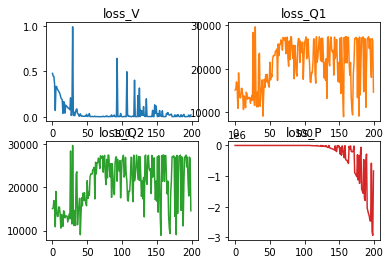

In [22]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(loss_V)
axs[0, 0].set_title('loss_V')
axs[0, 1].plot(loss_Q1, 'tab:orange')
axs[0, 1].set_title('loss_Q1')
axs[1, 0].plot(loss_Q2, 'tab:green')
axs[1, 0].set_title('loss_Q2')
axs[1, 1].plot(loss_P, 'tab:red')
axs[1, 1].set_title('loss_P')

In [23]:
loss_V[-1],loss_Q1[-1],loss_Q2[-1],loss_P[-1]

(DeviceArray(0.02, dtype=float32),
 DeviceArray(14591.242, dtype=float32),
 DeviceArray(14578.455, dtype=float32),
 DeviceArray(-832560.1, dtype=float32))

In [ ]:
iterations = 200
av_returns = []
for _ in trange(iterations):
  av_returns.append(evaluation_interaction_loop(pendulum_agent, env=pendulum_env, sequence_length=1000))
plt.plot(av_returns)
plt.title("Average returns over iterations")
plt.show()

 65%|██████▌   | 130/200 [35:36<19:06, 16.37s/it]

In [25]:
reacher_env = ReacherEnv(for_evaluation=False)
reacher_agent = SACAgent(seed=0,
                          learning_rates=[5e-4, 5e-4, 5e-4],
                          gamma=0.95,
                          tau=0.005,
                          value_output_sizes=[256, 256],
                          softQ_output_sizes=[256, 256],
                          policy_output_sizes=[256, 256],
                          environment_spec=acme.make_environment_spec(reacher_env)
                          )
iterations = -1
for _ in range(iterations):
  evaluation_interaction_loop(reacher_agent, env=reacher_env, sequence_length=200)